<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

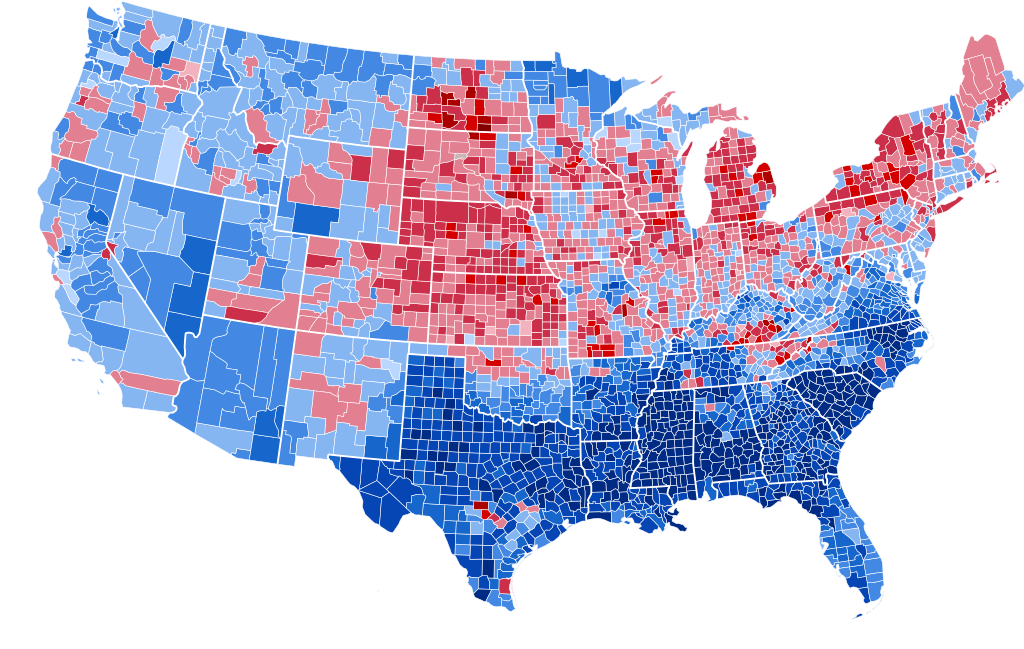

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings
warnings.filterwarnings('ignore')

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [2]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [3]:
def preprocess(df):    
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0

    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def test_preprocess(df):
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def package(preds, df):
    df['Result'][0:] = preds.astype(int)
    return df

In [4]:
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  18791  30012      0.385093   0.094595   
1      6035       Lassen County, CA   2026   6533      0.369908  -0.355212   
2     40081      Lincoln County, OK   2423  10838      0.333663  -0.025097   
3     31153        Sarpy County, NE  27704  44649      0.552519   0.177606   
4     28055    Issaquena County, MS    395    298      0.200261  -0.247104   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY   8717  18668      0.343395  -0.067568   
1551  55031      Douglas County, WI  11342   9657      0.373972  -0.050193   
1552  27065      Kanabec County, MN   2327   5230      0.381453   0.030888   
1553  17139     Moultrie County, IL   1476   4453      0.426769  -0.177606   
1554  20185     Stafford County, KS    303   1485      0.342503  -0.152510   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  Winner  
0      0.439863   0.384615      0.280161          0.174274       0  
1      0.316151   0.220280      0.160858          0.286307       0  
2      0.391753   0.409091      0.202413          0.219917       0  
3      0.487973   0.174825      0.537534          0.120332       0  
4      0.336770   0.185315      0.089812          0.580913       1  
...         ...        ...           ...               ...     ...  
1550   0.384880   0.377622      0.256032          0.248963       0  
1551   0.336770   0.356643      0.321716          0.215768       1  
1552   0.347079   0.363636      0.195710          0.269710       0  
1553   0.443299   0.454545      0.261394          0.190871       0  
1554   0.443299   0.423077      0.320375          0.153527       0  

[1555 rows x 11 columns]

In [5]:
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  20775  25422      0.413372   0.000832   
1      6035       Lassen County, CA   3044   7261      0.399213  -0.164725   
2     40081      Lincoln County, OK   3265   9542      0.371206  -0.023295   
3     31153        Sarpy County, NE  24709  40318      0.572738   0.066556   
4     28055    Issaquena County, MS    479    302      0.242874   0.018303   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY  11695  15406      0.360048  -0.062396   
1551  55031      Douglas County, WI  14855   7698      0.366363  -0.054077   
1552  27065      Kanabec County, MN   3586   4319      0.371879  -0.122296   
1553  17139     Moultrie County, IL   2142   3781      0.427624   0.006656   
1554  20185     Stafford County, KS    403   1382      0.363563  -0.038270   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  Winner  
0      0.458042   0.431111      0.273611          0.284672       0  
1      0.314685   0.355556      0.179167          0.456204       0  
2      0.395105   0.493333      0.181944          0.182482       0  
3      0.555944   0.217778      0.508333          0.142336       0  
4      0.300699   0.320000      0.108333          0.642336       1  
...         ...        ...           ...               ...     ...  
1550   0.409091   0.448889      0.250000          0.339416       0  
1551   0.384615   0.404444      0.304167          0.251825       1  
1552   0.248252   0.364444      0.186111          0.328467       0  
1553   0.430070   0.528889      0.215278          0.259124       0  
1554   0.360140   0.568889      0.281944          0.167883       0  

[1555 rows x 11 columns]

In [6]:
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph


SRC    DST
0       1001   1001
1       1001   1021
2       1001   1047
3       1001   1051
4       1001   1085
...      ...    ...
12712  72153  72153
12713  78010  78010
12714  78020  78020
12715  78020  78030
12716  78030  78030

[12717 rows x 2 columns]

In [7]:
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

FIPS  Result
0     17059       0
1      6103       0
2     42047       0
3     47147       0
4     39039       0
...     ...     ...
1550  55095       0
1551  34035       0
1552  42107       0
1553  48293       0
1554  37087       0

[1555 rows x 2 columns]

In [8]:
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16


FIPS                 County  MedianIncome  MigraRate  BirthRate  \
0     17059    Gallatin County, IL      0.335782  -0.050548   0.378947   
1      6103      Tehama County, CA      0.343839   0.008584   0.449123   
2     42047         Elk County, PA      0.417452  -0.044349   0.340351   
3     47147   Robertson County, TN      0.495506   0.035289   0.445614   
4     39039    Defiance County, OH      0.442326  -0.025274   0.389474   
...     ...                    ...           ...        ...        ...   
1550  55095        Polk County, WI      0.454619   0.006676   0.333333   
1551  34035    Somerset County, NJ      0.886754  -0.009061   0.354386   
1552  42107  Schuylkill County, PA      0.426136  -0.000477   0.326316   
1553  48293   Limestone County, TX      0.333647   0.002384   0.463158   
1554  37087     Haywood County, NC      0.383700   0.071531   0.354386   

      DeathRate  BachelorRate  UnemploymentRate  
0      0.363372      0.126115          0.381910  
1      0.302326      0.197452          0.356784  
2      0.377907      0.236943          0.276382  
3      0.281977      0.236943          0.206030  
4      0.296512      0.212739          0.246231  
...         ...           ...               ...  
1550   0.313953      0.259873          0.231156  
1551   0.209302      0.694268          0.206030  
1552   0.389535      0.206369          0.311558  
1553   0.328488      0.178344          0.281407  
1554   0.366279      0.318471          0.226131  

[1555 rows x 8 columns]

In [9]:
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

FIPS                 County  MedianIncome  MigraRate  BirthRate  \
0     17059    Gallatin County, IL      0.314441  -0.128660   0.299003   
1      6103      Tehama County, CA      0.318161  -0.031056   0.378738   
2     42047         Elk County, PA      0.401674  -0.026619   0.322259   
3     47147   Robertson County, TN      0.445897  -0.039929   0.475083   
4     39039    Defiance County, OH      0.382532  -0.057675   0.385382   
...     ...                    ...           ...        ...        ...   
1550  55095        Polk County, WI      0.412586  -0.099379   0.318937   
1551  34035    Somerset County, NJ      0.788239   0.000000   0.345515   
1552  42107  Schuylkill County, PA      0.366433   0.007098   0.328904   
1553  48293   Limestone County, TX      0.300998   0.011535   0.451827   
1554  37087     Haywood County, NC      0.330078   0.007098   0.328904   

      DeathRate  BachelorRate  UnemploymentRate  
0      0.570796      0.142477          0.351464  
1      0.420354      0.187750          0.573222  
2      0.548673      0.205060          0.292887  
3      0.415929      0.225033          0.292887  
4      0.433628      0.217044          0.322176  
...         ...           ...               ...  
1550   0.371681      0.255659          0.334728  
1551   0.300885      0.692410          0.309623  
1552   0.584071      0.198402          0.405858  
1553   0.469027      0.181092          0.288703  
1554   0.526549      0.316911          0.380753  

[1555 rows x 8 columns]

<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [10]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search with cross-validation
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [11]:
# Basic Model 2 - SVM with RBF Kernel 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search with cross-validation.
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [12]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [13]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

# Cross-validate on hyperparameters for model selection
best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8294589416858154, 2, 'minkowski']


In [14]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

# Cross-validate on hyperparameters for model selection
best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

[0.8541057735917128, 128.0, 2.6666666666666665]


In [15]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](kaggle_submission_basic.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [16]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# Feature Engineering TODO: 
# graph data get % of neighbors voting D in 2012,
# Model TODO: regularization like https://medium.com/datadriveninvestor/a-simple-way-to-know-how-important-your-input-is-in-neural-network-86cbae0d3689 or/and https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ 
# TODO 

### 3.1.1 Import Statements

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR) # suppress TF warnings from being printed
tf.random.set_seed(123)

from IPython.display import clear_output
from matplotlib import pyplot as plt


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [18]:
def gen_class_weights(df):
    df['Weight'] = 0.0
    # rationale: training data has roughly 5.9 ratio of GOP counties to DEM
    d_weight = 5.0 
    r_weight = 1.0
    # assign weights accordingly
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight
       
    return df

def gen_labels(df):
    # Binary Indicator of Dem or GOP winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
       
    return df

def norm_preprocess(df):    
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col] / factor
    return df

def ratio_preprocess(df):    
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] = mult * d / total_pop
    return df

def cthresh(preds, thresh = 0.5):
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [19]:
# Read train/test data from given CSVs and preprocess the test data

rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = gen_labels(rawdf16)

rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = gen_labels(rawdf12)

dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')

dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')

rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)

rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [20]:
def graph_process(d16, graph, result, result12):
    # Adds extra features to the dataframe based on the graph structure of counties
    # Graph DST sorted least to greatest, other neighbors < DST FIPS can occur but with that DST as SRC
    neigh_exist, neigh_vote, neigh_swing, neigh_pop = [], [], [], []
    for row in range(len(d16)):
        # get current neighbors of county by FIPS
        neighbors = np.array(dfgraph[dfgraph['SRC'] == d16['FIPS'][row]]['DST'][1:])
        neighbors = np.append(neighbors,np.array(dfgraph[dfgraph['DST'] == d16['FIPS'][row]]['SRC'][:-1]))
        prop, swing = [], []
        dem, gop = 0, 0
        for neigh in neighbors:
            if len(result[result['FIPS'] == neigh]) > 0:
                prop = np.append(prop, np.array(result[result['FIPS'] == neigh]['Winner']))
                swing = np.append(swing, np.array(np.abs(np.array(result[result['FIPS'] == neigh]['Winner'])[0] - np.array(result12[result12['FIPS'] == neigh]['Winner'])[0])))
                dem += np.array(result[result['FIPS'] == neigh]['DEM'])[0]
                gop += np.array(result[result['FIPS'] == neigh]['GOP'])[0]
        if len(prop) == 0:
            neigh_vote.append(0.5)
            neigh_exist.append(0)
            neigh_swing.append(0.5)
            neigh_pop.append(0.5)
        else:
            neigh_vote.append(np.mean(prop))
            neigh_exist.append(1)
            neigh_swing.append(np.mean(swing))
            neigh_pop.append(dem / (dem + gop))

    # add feature columns to training data
    d16['neigh_vote'] = np.array(neigh_vote)
    d16['neigh_exist'] = np.array(neigh_exist)
    d16['neigh_swing'] = np.array(neigh_swing)
    d16['neigh_pop'] = np.array(neigh_pop)
    return d16

In [21]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())    
    creative = graph_process(creative.copy(), graph.copy(), df16.copy(), df12.copy())
    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    
    # GENERATE 2012 COLS
    for cols in norm_cols:
        delta = np.array(d12[cols])
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
    
    # GENERATE DIFF COLS
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENERATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative

traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
neigh_vote              float64
neigh_exist               int32
neigh_swing             float64
neigh_pop               float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


FIPS                  County    DEM    GOP  MedianIncome  MigraRate  \
0     18019        Clark County, IN  18791  30012      0.385093   0.094595   
1      6035       Lassen County, CA   2026   6533      0.369908  -0.355212   
2     40081      Lincoln County, OK   2423  10838      0.333663  -0.025097   
3     31153        Sarpy County, NE  27704  44649      0.552519   0.177606   
4     28055    Issaquena County, MS    395    298      0.200261  -0.247104   
...     ...                     ...    ...    ...           ...        ...   
1550  36009  Cattaraugus County, NY   8717  18668      0.343395  -0.067568   
1551  55031      Douglas County, WI  11342   9657      0.373972  -0.050193   
1552  27065      Kanabec County, MN   2327   5230      0.381453   0.030888   
1553  17139     Moultrie County, IL   1476   4453      0.426769  -0.177606   
1554  20185     Stafford County, KS    303   1485      0.342503  -0.152510   

      BirthRate  DeathRate  BachelorRate  UnemploymentRate  ...  \
0      0.439863   0.384615      0.280161          0.174274  ...   
1      0.316151   0.220280      0.160858          0.286307  ...   
2      0.391753   0.409091      0.202413          0.219917  ...   
3      0.487973   0.174825      0.537534          0.120332  ...   
4      0.336770   0.185315      0.089812          0.580913  ...   
...         ...        ...           ...               ...  ...   
1550   0.384880   0.377622      0.256032          0.248963  ...   
1551   0.336770   0.356643      0.321716          0.215768  ...   
1552   0.347079   0.363636      0.195710          0.269710  ...   
1553   0.443299   0.454545      0.261394          0.190871  ...   
1554   0.443299   0.423077      0.320375          0.153527  ...   

      BachelorRate2012  UnemploymentRate2012  MedianIncomeDiff  MigraRateDiff  \
0             0.273611              0.284672          0.116587       0.073282   
1             0.179167              0.456204          0.100885       0.021374   
2             0.181944              0.182482          0.033367       0.022901   
3             0.508333              0.142336          0.272866       0.018321   
4             0.108333              0.642336         -0.084137      -0.229008   
...                ...                   ...               ...            ...   
1550          0.250000              0.339416          0.148384       0.061069   
1551          0.304167              0.251825          0.295154       0.059542   
1552          0.186111              0.328467          0.310464       0.248855   
1553          0.215278              0.259124          0.287347      -0.152672   
1554          0.281944              0.167883          0.124918      -0.050382   

     BirthRateDiff  DeathRateDiff  BachelorRateDiff  UnemploymentRateDiff  \
0        -0.032967       0.110169          0.063492             -0.734694   
1         0.021978      -0.144068         -0.047619             -1.142857   
2         0.010989       0.050847          0.105820              0.061224   
3        -0.186813       0.008475          0.185185             -0.204082   
4         0.131868      -0.161017         -0.058201             -0.734694   
...            ...            ...               ...                   ...   
1550     -0.054945       0.059322          0.058201             -0.673469   
1551     -0.131868       0.093220          0.111111             -0.346939   
1552      0.329670       0.186441          0.063492             -0.510204   
1553      0.065934       0.093220          0.211640             -0.510204   
1554      0.285714      -0.059322          0.190476             -0.183673   

      Weight  Winner  
0        1.0       0  
1        1.0       0  
2        1.0       0  
3        1.0       0  
4        5.0       1  
...      ...     ...  
1550     1.0       0  
1551     5.0       1  
1552     1.0       0  
1553     1.0       0  
1554     1.0       0  

[1555 rows x 29 columns]

### 3.1.3 Actual Code


In [22]:
print(tf.__version__)

df16 = traindf
test16 = testdf

df16.head()

label_idx = len(df16.columns) - 1
stop_idx = label_idx
train_x = df16.iloc[0:,4:stop_idx]
train_y = df16.iloc[0:,label_idx]
test_x = test16.iloc[0:,2:]

# split = 1555 # splitting idx
split = 1100

N,d = train_x.shape

dftrain = train_x.iloc[:split,:]
y_train = train_y.iloc[:split]
dfeval = train_x.iloc[split:,:]
y_eval = train_y.iloc[split:]

2.3.1


In [23]:
# Constants for use in model
CATEGORICAL_COLUMNS = []
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []
NUMERIC_GRAPH_EXTEND = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]

NUMERIC_GRAPH_EXTEND = ['neigh_vote', 'neigh_swing', 'neigh_pop']

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF
NUMERIC_COLUMNS += NUMERIC_GRAPH_EXTEND

REMOVE = ['MigraRate', 'MigraRate2012', 'BirthRate']
# REMOVE += ['UnemploymentRate2016','BirthRate2012']
NUMERIC_COLUMNS = [x for x in NUMERIC_COLUMNS if x not in REMOVE]

In [24]:
# Model util functions
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

[ *** ] STEP MAX: 50
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                 0.753564
accuracy_baseline        0.541752
auc                      0.844737
auc_precision_recall     0.780399
average_loss             0.540073
label/mean               0.458248
loss                     0.852655
precision                0.740741
prediction/mean          0.471998
recall                   0.711111
global_step             50.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7502923976608188
[ $ ] VALIDATION ACCURACY OVER TIME: 


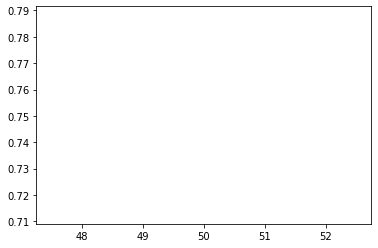

[ $$$ ] TEST


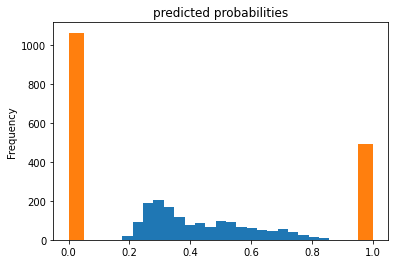

[ *** ] STEP MAX: 100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.812632
accuracy_baseline         0.568421
auc                       0.878184
auc_precision_recall      0.835990
average_loss              0.466915
label/mean                0.431579
loss                      0.713133
precision                 0.771028
prediction/mean           0.465706
recall                    0.804878
global_step             100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8116982836495032
[ $ ] VALIDATION ACCURACY OVER TIME: 


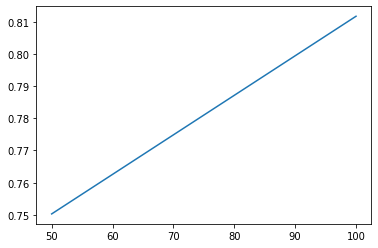

[ $$$ ] TEST


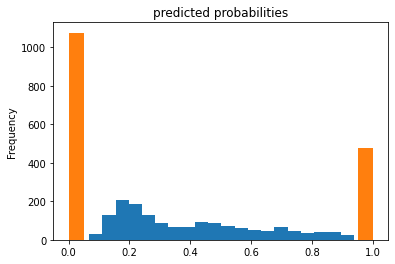

[ *** ] STEP MAX: 150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.833676
accuracy_baseline         0.548255
auc                       0.920114
auc_precision_recall      0.906309
average_loss              0.387211
label/mean                0.451745
loss                      0.606339
precision                 0.814480
prediction/mean           0.467770
recall                    0.818182
global_step             150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8323118828736806
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


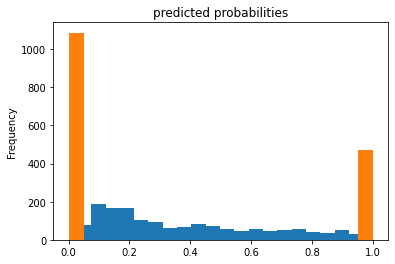

[ *** ] STEP MAX: 200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.770874
accuracy_baseline         0.504854
auc                       0.887104
auc_precision_recall      0.890416
average_loss              0.434548
label/mean                0.495146
loss                      0.719588
precision                 0.837438
prediction/mean           0.440252
recall                    0.666667
global_step             200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7698717948717948
[ $ ] VALIDATION ACCURACY OVER TIME: 


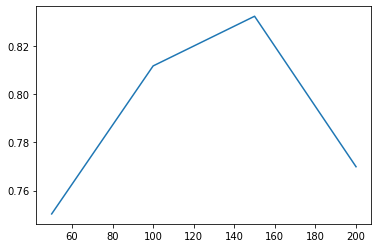

[ $$$ ] TEST


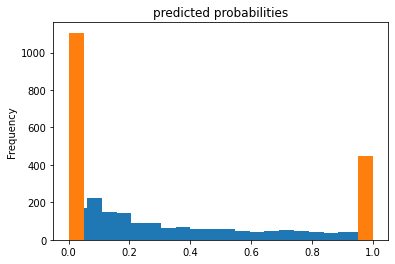

[ *** ] STEP MAX: 250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.792608
accuracy_baseline         0.548255
auc                       0.880916
auc_precision_recall      0.854276
average_loss              0.428247
label/mean                0.451745
loss                      0.670598
precision                 0.796020
prediction/mean           0.430298
recall                    0.727273
global_step             250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7868573374191351
[ $ ] VALIDATION ACCURACY OVER TIME: 


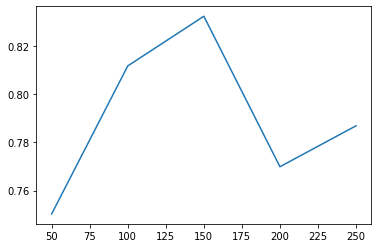

[ $$$ ] TEST


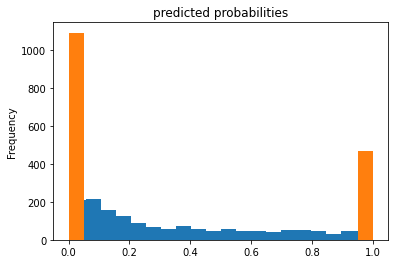

[ *** ] STEP MAX: 300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.822811
accuracy_baseline         0.541752
auc                       0.923308
auc_precision_recall      0.880570
average_loss              0.361201
label/mean                0.458248
loss                      0.570256
precision                 0.797414
prediction/mean           0.477506
recall                    0.822222
global_step             300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.822765246449457
[ $ ] VALIDATION ACCURACY OVER TIME: 


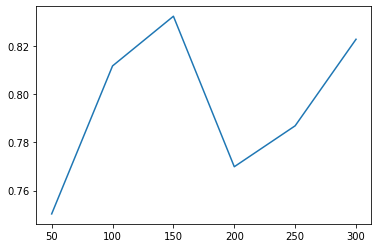

[ $$$ ] TEST


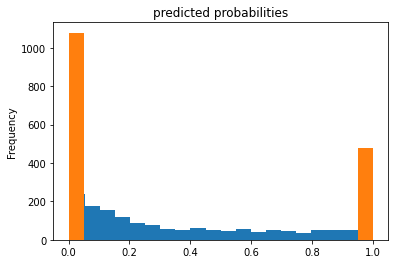

[ *** ] STEP MAX: 350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.800000
accuracy_baseline         0.568421
auc                       0.906278
auc_precision_recall      0.872567
average_loss              0.382506
label/mean                0.431579
loss                      0.584214
precision                 0.789474
prediction/mean           0.442088
recall                    0.731707
global_step             350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7917795844625113
[ $ ] VALIDATION ACCURACY OVER TIME: 


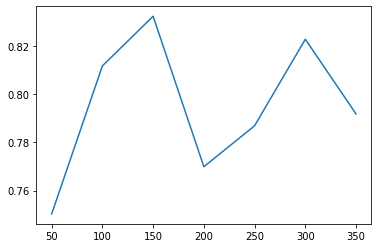

[ $$$ ] TEST


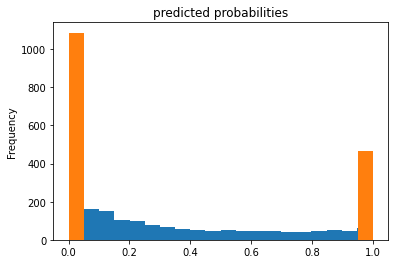

[ *** ] STEP MAX: 400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.845996
accuracy_baseline         0.548255
auc                       0.948246
auc_precision_recall      0.938204
average_loss              0.311586
label/mean                0.451745
loss                      0.487917
precision                 0.837209
prediction/mean           0.449425
recall                    0.818182
global_step             400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8435478379298604
[ $ ] VALIDATION ACCURACY OVER TIME: 


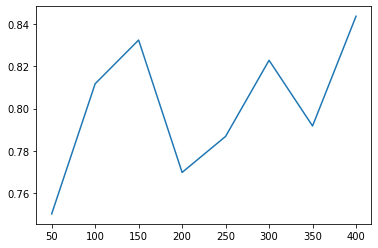

[ $$$ ] TEST


[ *** ] STEP MAX: 450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.770874
accuracy_baseline         0.504854
auc                       0.916290
auc_precision_recall      0.916011
average_loss              0.373665
label/mean                0.495146
loss                      0.618770
precision                 0.837438
prediction/mean           0.442765
recall                    0.666667
global_step             450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7698717948717948
[ $ ] VALIDATION ACCURACY OVER TIME: 


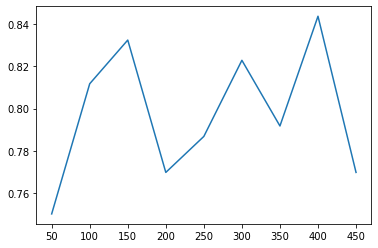

[ $$$ ] TEST


[ *** ] STEP MAX: 500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.821355
accuracy_baseline         0.548255
auc                       0.914283
auc_precision_recall      0.894080
average_loss              0.364701
label/mean                0.451745
loss                      0.571092
precision                 0.821256
prediction/mean           0.431070
recall                    0.772727
global_step             500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8170752468505278
[ $ ] VALIDATION ACCURACY OVER TIME: 


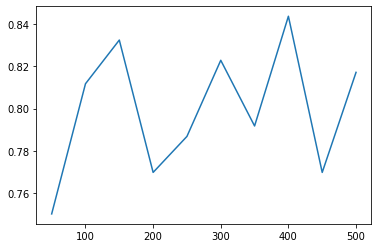

[ $$$ ] TEST


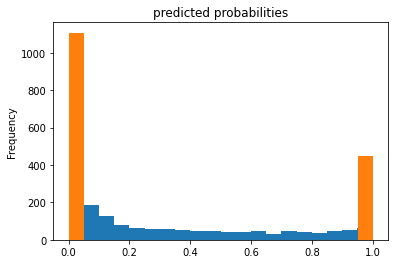

[ *** ] STEP MAX: 550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.873727
accuracy_baseline         0.541752
auc                       0.953091
auc_precision_recall      0.918955
average_loss              0.293563
label/mean                0.458248
loss                      0.463470
precision                 0.829960
prediction/mean           0.488177
recall                    0.911111
global_step             550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.876608187134503
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.831579
accuracy_baseline         0.568421
auc                       0.918925
auc_precision_recall      0.893482
average_loss              0.358000
label/mean                0.431579
loss                      0.546785
precision                 0.820513
prediction/mean           0.427140
recall                    0.780488
global_step             600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8254290876242096
[ $ ] VALIDATION ACCURACY OVER TIME: 


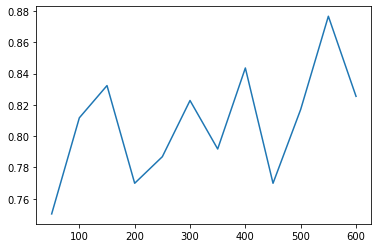

[ $$$ ] TEST


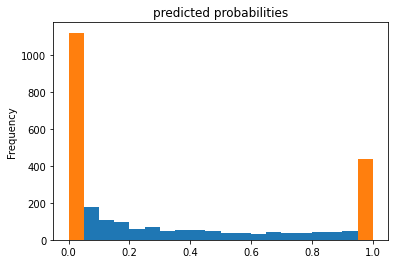

[ *** ] STEP MAX: 650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.850103
accuracy_baseline         0.548255
auc                       0.955439
auc_precision_recall      0.945937
average_loss              0.288831
label/mean                0.451745
loss                      0.452286
precision                 0.862069
prediction/mean           0.435649
recall                    0.795455
global_step             650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8452928157984338
[ $ ] VALIDATION ACCURACY OVER TIME: 


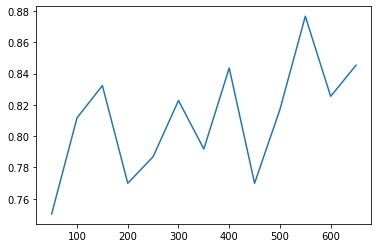

[ $$$ ] TEST


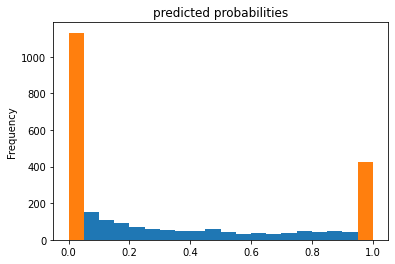

[ *** ] STEP MAX: 700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.801942
accuracy_baseline         0.504854
auc                       0.931109
auc_precision_recall      0.929310
average_loss              0.344526
label/mean                0.495146
loss                      0.570517
precision                 0.869565
prediction/mean           0.443229
recall                    0.705882
global_step             700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8010180995475112
[ $ ] VALIDATION ACCURACY OVER TIME: 


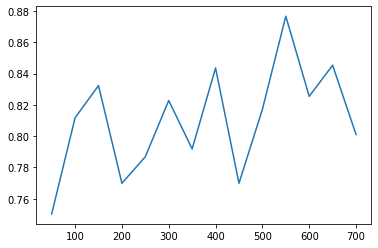

[ $$$ ] TEST


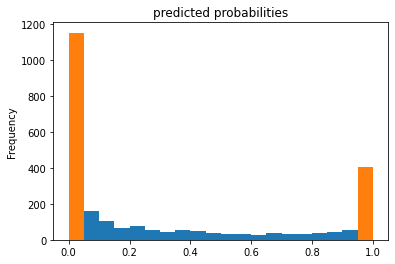

[ *** ] STEP MAX: 750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.845996
accuracy_baseline         0.548255
auc                       0.933819
auc_precision_recall      0.915957
average_loss              0.324085
label/mean                0.451745
loss                      0.507490
precision                 0.837209
prediction/mean           0.436927
recall                    0.818182
global_step             750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8435478379298604
[ $ ] VALIDATION ACCURACY OVER TIME: 


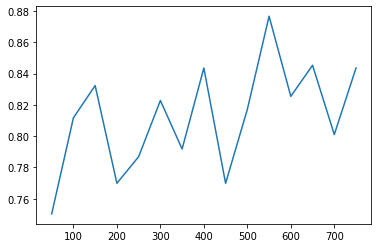

[ $$$ ] TEST


[ *** ] STEP MAX: 800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.898167
accuracy_baseline         0.541752
auc                       0.964745
auc_precision_recall      0.939880
average_loss              0.258618
label/mean                0.458248
loss                      0.408300
precision                 0.843137
prediction/mean           0.494827
recall                    0.955556
global_step             800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9025898078529658
[ $ ] VALIDATION ACCURACY OVER TIME: 


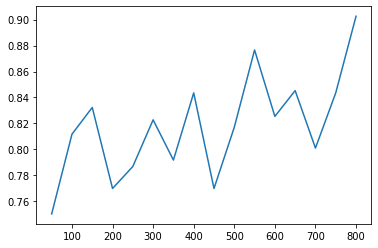

[ $$$ ] TEST


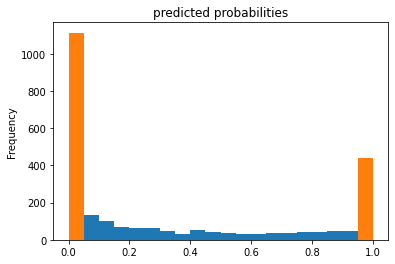

[ *** ] STEP MAX: 850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.844211
accuracy_baseline         0.568421
auc                       0.921951
auc_precision_recall      0.897805
average_loss              0.351250
label/mean                0.431579
loss                      0.536475
precision                 0.829146
prediction/mean           0.418096
recall                    0.804878
global_step             850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.839476061427281
[ $ ] VALIDATION ACCURACY OVER TIME: 


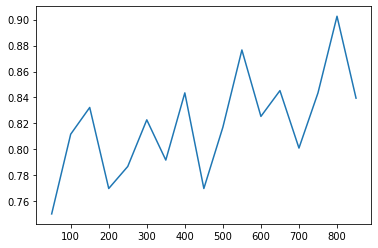

[ $$$ ] TEST


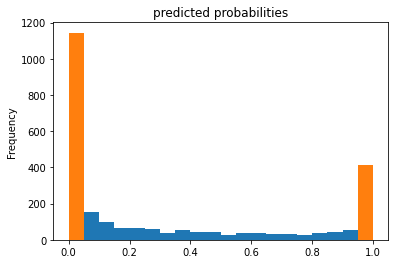

[ *** ] STEP MAX: 900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.850103
accuracy_baseline         0.548255
auc                       0.956631
auc_precision_recall      0.946768
average_loss              0.276716
label/mean                0.451745
loss                      0.433314
precision                 0.862069
prediction/mean           0.429443
recall                    0.795455
global_step             900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8452928157984338
[ $ ] VALIDATION ACCURACY OVER TIME: 


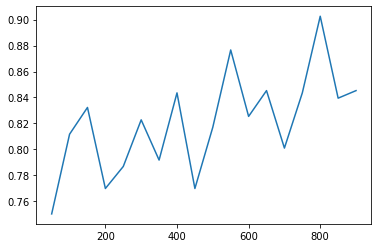

[ $$$ ] TEST


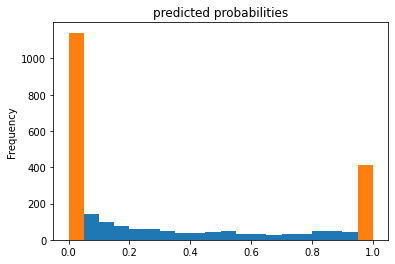

[ *** ] STEP MAX: 950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.811651
accuracy_baseline         0.504854
auc                       0.941176
auc_precision_recall      0.938578
average_loss              0.323457
label/mean                0.495146
loss                      0.535628
precision                 0.872642
prediction/mean           0.444596
recall                    0.725490
global_step             950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8108220211161388
[ $ ] VALIDATION ACCURACY OVER TIME: 


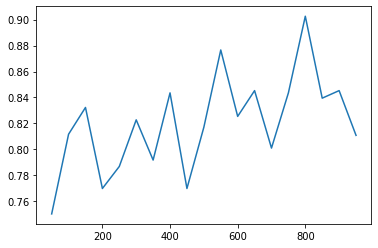

[ $$$ ] TEST


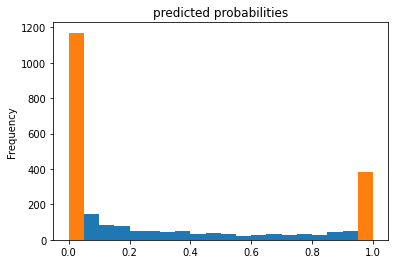

[ *** ] STEP MAX: 1000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.876797
accuracy_baseline          0.548255
auc                        0.944459
auc_precision_recall       0.929470
average_loss               0.296589
label/mean                 0.451745
loss                       0.464434
precision                  0.863636
prediction/mean            0.442451
recall                     0.863636
global_step             1000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8756384065372829
[ $ ] VALIDATION ACCURACY OVER TIME: 


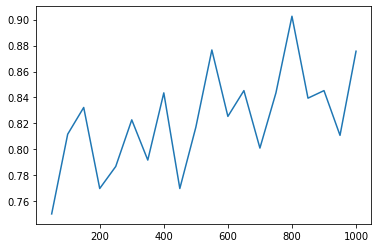

[ $$$ ] TEST


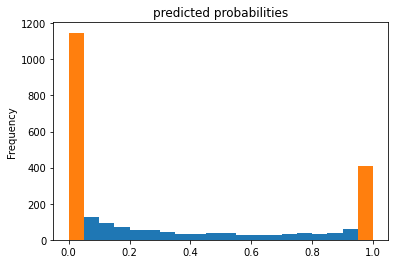

[ *** ] STEP MAX: 1050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.922607
accuracy_baseline          0.541752
auc                        0.970050
auc_precision_recall       0.947919
average_loss               0.234742
label/mean                 0.458248
loss                       0.370605
precision                  0.869565
prediction/mean            0.496170
recall                     0.977778
global_step             1050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.926858813700919
[ $ ] VALIDATION ACCURACY OVER TIME: 


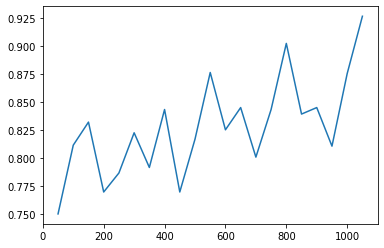

[ $$$ ] TEST


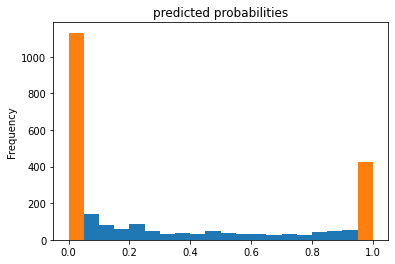

[ *** ] STEP MAX: 1100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.848421
accuracy_baseline          0.568421
auc                        0.925881
auc_precision_recall       0.901437
average_loss               0.347500
label/mean                 0.431579
loss                       0.530748
precision                  0.837563
prediction/mean            0.412146
recall                     0.804878
global_step             1100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8431797651309847
[ $ ] VALIDATION ACCURACY OVER TIME: 


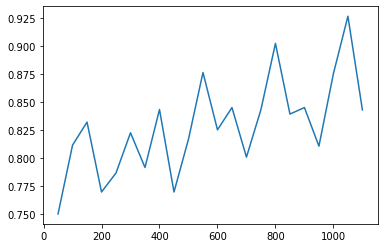

[ $$$ ] TEST


[ *** ] STEP MAX: 1150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.841889
accuracy_baseline          0.548255
auc                        0.960206
auc_precision_recall       0.951444
average_loss               0.264028
label/mean                 0.451745
loss                       0.413446
precision                  0.862944
prediction/mean            0.423320
recall                     0.772727
global_step             1150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8358018386108274
[ $ ] VALIDATION ACCURACY OVER TIME: 


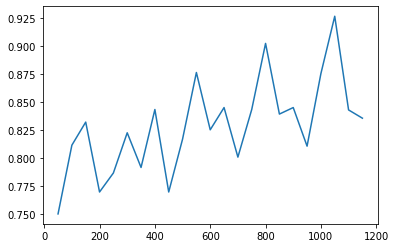

[ $$$ ] TEST


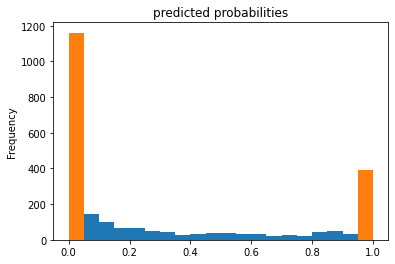

[ *** ] STEP MAX: 1200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.833010
accuracy_baseline          0.504854
auc                        0.947398
auc_precision_recall       0.944630
average_loss               0.302347
label/mean                 0.495146
loss                       0.500672
precision                  0.882353
prediction/mean            0.444471
recall                     0.764706
global_step             1200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8323529411764706
[ $ ] VALIDATION ACCURACY OVER TIME: 


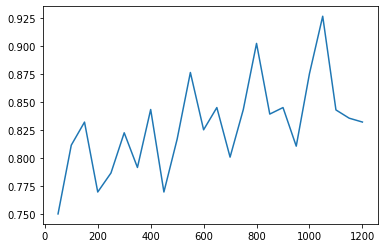

[ $$$ ] TEST


[ *** ] STEP MAX: 1250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.878850
accuracy_baseline          0.548255
auc                        0.953567
auc_precision_recall       0.939786
average_loss               0.275653
label/mean                 0.451745
loss                       0.431649
precision                  0.867580
prediction/mean            0.442201
recall                     0.863636
global_step             1250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8775110657133128
[ $ ] VALIDATION ACCURACY OVER TIME: 


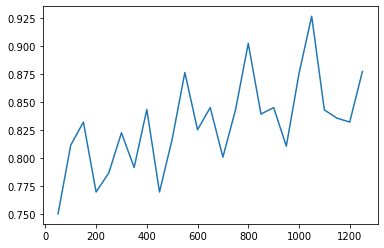

[ $$$ ] TEST


[ *** ] STEP MAX: 1300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.930754
accuracy_baseline          0.541752
auc                        0.976190
auc_precision_recall       0.958309
average_loss               0.213036
label/mean                 0.458248
loss                       0.336336
precision                  0.883534
prediction/mean            0.496630
recall                     0.977778
global_step             1300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9343776106934003
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


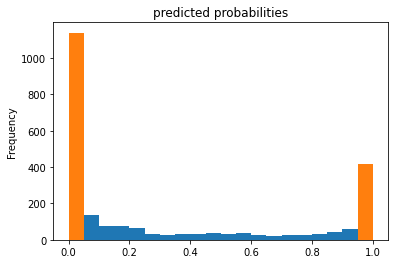

[ *** ] STEP MAX: 1350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.850526
accuracy_baseline          0.568421
auc                        0.932340
auc_precision_recall       0.910199
average_loss               0.335588
label/mean                 0.431579
loss                       0.512555
precision                  0.841837
prediction/mean            0.409855
recall                     0.804878
global_step             1350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8450316169828365
[ $ ] VALIDATION ACCURACY OVER TIME: 


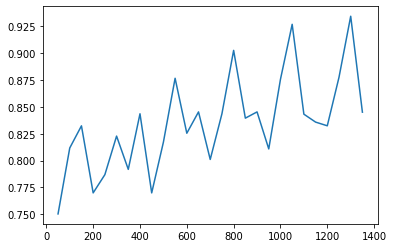

[ $$$ ] TEST


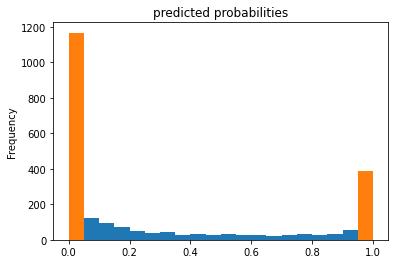

[ *** ] STEP MAX: 1400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.864476
accuracy_baseline          0.548255
auc                        0.965313
auc_precision_recall       0.957811
average_loss               0.243728
label/mean                 0.451745
loss                       0.381657
precision                  0.873786
prediction/mean            0.424765
recall                     0.818182
global_step             1400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8604017705141301
[ $ ] VALIDATION ACCURACY OVER TIME: 


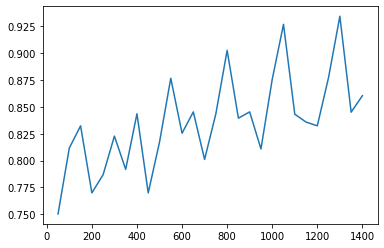

[ $$$ ] TEST


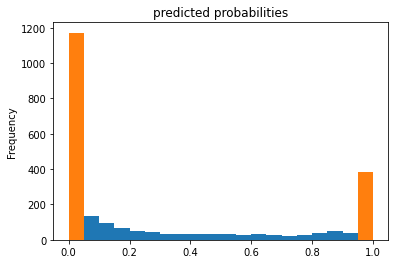

[ *** ] STEP MAX: 1450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.856311
accuracy_baseline          0.504854
auc                        0.954902
auc_precision_recall       0.953333
average_loss               0.279963
label/mean                 0.495146
loss                       0.463605
precision                  0.913242
prediction/mean            0.445700
recall                     0.784314
global_step             1450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8556184012066365
[ $ ] VALIDATION ACCURACY OVER TIME: 


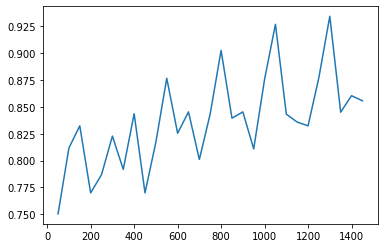

[ $$$ ] TEST


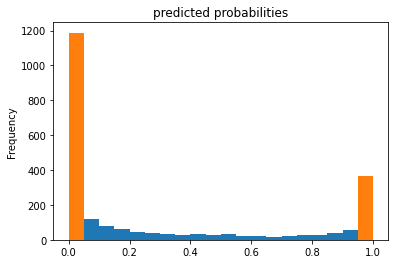

[ *** ] STEP MAX: 1500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.885010
accuracy_baseline          0.548255
auc                        0.958589
auc_precision_recall       0.944727
average_loss               0.256629
label/mean                 0.451745
loss                       0.401859
precision                  0.879630
prediction/mean            0.441593
recall                     0.863636
global_step             1500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8831290432414028
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 1550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.930754
accuracy_baseline          0.541752
auc                        0.979825
auc_precision_recall       0.964627
average_loss               0.197690
label/mean                 0.458248
loss                       0.312109
precision                  0.883534
prediction/mean            0.496662
recall                     0.977778
global_step             1550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9343776106934003
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 1600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.852632
accuracy_baseline          0.568421
auc                        0.937353
auc_precision_recall       0.916256
average_loss               0.326604
label/mean                 0.431579
loss                       0.498833
precision                  0.846154
prediction/mean            0.406852
recall                     0.804878
global_step             1600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8468834688346885
[ $ ] VALIDATION ACCURACY OVER TIME: 


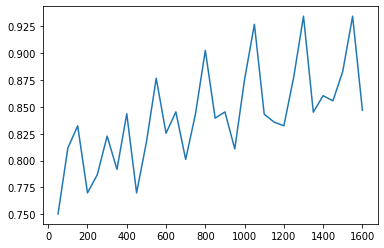

[ $$$ ] TEST


[ *** ] STEP MAX: 1650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.876797
accuracy_baseline          0.548255
auc                        0.970804
auc_precision_recall       0.964313
average_loss               0.225907
label/mean                 0.451745
loss                       0.353751
precision                  0.880952
prediction/mean            0.427741
recall                     0.840909
global_step             1650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8736380660537963
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


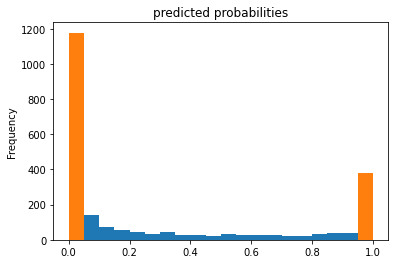

[ *** ] STEP MAX: 1700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866019
accuracy_baseline          0.504854
auc                        0.962783
auc_precision_recall       0.962090
average_loss               0.260457
label/mean                 0.495146
loss                       0.431303
precision                  0.915179
prediction/mean            0.447009
recall                     0.803922
global_step             1700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.865422322775264
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 1750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.885010
accuracy_baseline          0.548255
auc                        0.964122
auc_precision_recall       0.951336
average_loss               0.239556
label/mean                 0.451745
loss                       0.375125
precision                  0.879630
prediction/mean            0.444457
recall                     0.863636
global_step             1750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8831290432414028
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 1800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.932790
accuracy_baseline          0.541752
auc                        0.982247
auc_precision_recall       0.968466
average_loss               0.184638
label/mean                 0.458248
loss                       0.291503
precision                  0.887097
prediction/mean            0.494202
recall                     0.977778
global_step             1800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9362573099415205
[ $ ] VALIDATION ACCURACY OVER TIME: 


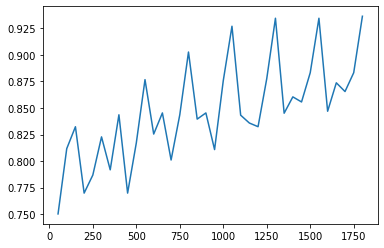

[ $$$ ] TEST


[ *** ] STEP MAX: 1850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.856842
accuracy_baseline          0.568421
auc                        0.941418
auc_precision_recall       0.921553
average_loss               0.316022
label/mean                 0.431579
loss                       0.482670
precision                  0.854922
prediction/mean            0.404113
recall                     0.804878
global_step             1850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8505871725383922
[ $ ] VALIDATION ACCURACY OVER TIME: 


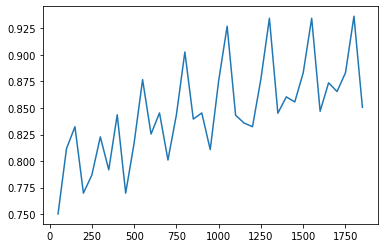

[ $$$ ] TEST


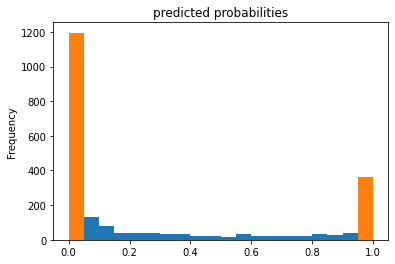

[ *** ] STEP MAX: 1900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.893224
accuracy_baseline          0.548255
auc                        0.973910
auc_precision_recall       0.967981
average_loss               0.213180
label/mean                 0.451745
loss                       0.333823
precision                  0.896226
prediction/mean            0.428035
recall                     0.863636
global_step             1900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8906196799455227
[ $ ] VALIDATION ACCURACY OVER TIME: 


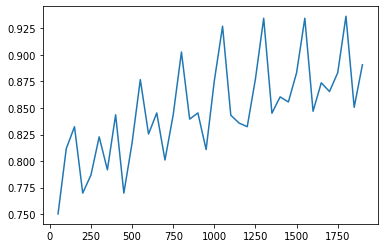

[ $$$ ] TEST


[ *** ] STEP MAX: 1950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.897087
accuracy_baseline          0.504854
auc                        0.967308
auc_precision_recall       0.966514
average_loss               0.243566
label/mean                 0.495146
loss                       0.403333
precision                  0.924370
prediction/mean            0.446744
recall                     0.862745
global_step             1950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8967571644042232
[ $ ] VALIDATION ACCURACY OVER TIME: 


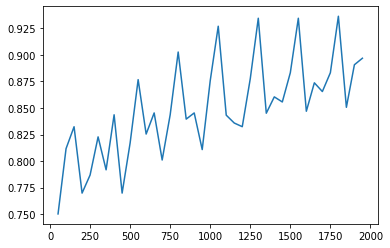

[ $$$ ] TEST


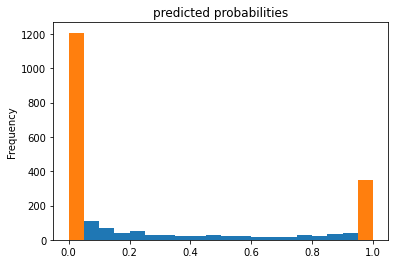

[ *** ] STEP MAX: 2000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.915811
accuracy_baseline          0.548255
auc                        0.967824
auc_precision_recall       0.956266
average_loss               0.224605
label/mean                 0.451745
loss                       0.351712
precision                  0.887446
prediction/mean            0.446506
recall                     0.931818
global_step             2000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9172199523323118
[ $ ] VALIDATION ACCURACY OVER TIME: 


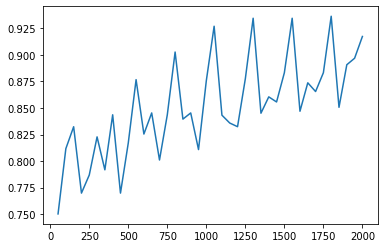

[ $$$ ] TEST


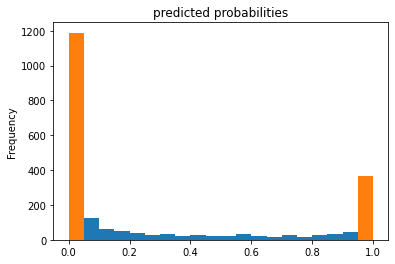

[ *** ] STEP MAX: 2050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.940937
accuracy_baseline          0.541752
auc                        0.983960
auc_precision_recall       0.971741
average_loss               0.174390
label/mean                 0.458248
loss                       0.275323
precision                  0.901639
prediction/mean            0.493536
recall                     0.977778
global_step             2050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9437761069340017
[ $ ] VALIDATION ACCURACY OVER TIME: 


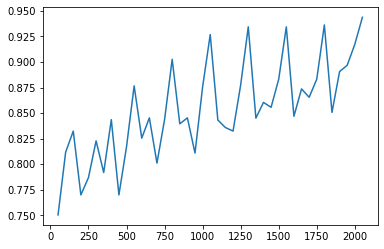

[ $$$ ] TEST


[ *** ] STEP MAX: 2100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.869474
accuracy_baseline          0.568421
auc                        0.945574
auc_precision_recall       0.927038
average_loss               0.305244
label/mean                 0.431579
loss                       0.466208
precision                  0.862944
prediction/mean            0.404905
recall                     0.829268
global_step             2100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8646341463414635
[ $ ] VALIDATION ACCURACY OVER TIME: 


[ $$$ ] TEST


[ *** ] STEP MAX: 2150
[ $$$ ] TRAINING


KeyboardInterrupt: 

In [25]:
# CREATIVE MODEL

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))
DNN_NUMERIC_COLUMNS = []
DNN_NUMERIC_COLUMNS = ['neigh_vote', 'neigh_swing', 'neigh_pop']
dnn_feature_cols = feature_columns

# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

# Training and evaluation input functions.
og_train_input_fn = make_input_fn(train_x, train_y, shuffle=False, n_epochs=1)
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
test_input_fn = make_input_fn(test_x, None, shuffle=False, n_epochs=1)

# (k-1)/k size MINI BATCHING
trains = []
vals = []
k = 5
splitter = 1555//k
split_index = [splitter*i for i in range(k)]
back_idx = [splitter*(i+1) for i in range(k)]
back_idx[-1] = 1555
yvals = []

train_x1 = train_x
train_y1 = train_y

for i in range(k):
    train_x = train_x1.copy()
    train_y = train_y1.copy()
    tdf = pd.concat([train_x.iloc[:split_index[i],:], train_x.iloc[back_idx[i]:,:]])
    ty = pd.concat([train_y.iloc[:split_index[i]], train_y.iloc[back_idx[i]:]])
    
    df = train_x.iloc[split_index[i]:back_idx[i],:]
    y = train_y.iloc[split_index[i]:back_idx[i]]
    
    trains.append(make_input_fn(tdf, ty, shuffle = True))
    vals.append(make_input_fn(df,y,shuffle=False, n_epochs=1))
    yvals.append(y)

'''
Since data fits into memory, use entire dataset per layer. It will be faster.
Above one batch is defined as the entire dataset.
'''

weight_col = 'Weight'

# DNN??
est = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=feature_columns,
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,  
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = 'Weight',
    dnn_dropout = None,
    batch_norm = False
)

_run = True
n = 0
i = 3
scores = [0 for i in range(k)]

accs = []
ns = []

while _run:
    incr = 50
    n += incr
    
    # EARLY STOPPING
    if n > 100*incr:
        break
    
    # BATCH SELECTOR
    i += 1
    i = i%k
    
    print(f"[ *** ] STEP MAX: {n}")
    
    # Train on mini batches    
    train_input_fn = trains[i]
    eval_input_fn  = vals[i]

    print("[ $$$ ] TRAINING")
    # Train up to n steps
    est.train(train_input_fn, max_steps=n)
    
    # Eval.
    print("[ $$$ ] EVAL RESULTS:")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
    print(pd.Series(result))

    eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])
    
    eval_submission = cthresh(eval_preds, thresh = 0.5)
    w_acc = weighted_accuracy(eval_submission, yvals[i])
    accs.append(w_acc)
        
    scores[i] = w_acc
    print("[ $ ] WEIGHTED ACCURACY ON EVAL: ")
    print(w_acc)
    
    # Create a graph over time of 1/k validation accuracy
    print("[ $ ] VALIDATION ACCURACY OVER TIME: ")
    ns.append(n)
    plt.plot(ns,accs)
    plt.show()
    
    # Test and send to submission
    print("[ $$$ ] TEST")
    pred_dicts = list(est.predict(test_input_fn))
    
    preds = None
    preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    # Create histogram of the predictions
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    
    # Create a histogram of submission statistics
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    plt.show()
 
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')

    _run = w_acc < 1.01

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>